In [74]:
import torch
import torchvision
import math
import os

import numpy as np
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import xml.etree.ElementTree as Et

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image,ImageDraw

# %matplotlib inline
import random
class Crop_bd:

    def __init__(self, aspect = 0.75):
        self.aspect = 0.75
    
    def __call__(self, x):
        image, label = x
        o_size = image.size #[w, h]
        i = random.randint(0, int(o_size[0] * (1-self.aspect))) # hor = w
        j = random.randint(0, int(o_size[1] * (1-self.aspect))) # ver = h

        
        image = TF.crop(image, j,i,o_size[1]*self.aspect, o_size[0]*self.aspect) #ver, hor height, wid

        boxes = label['boxes']
        idx = torch.ones((len(boxes)))

        for k, box in enumerate(boxes):
            box[0] -= i
            box[2] -= i
            box[1] -= j
            box[3] -= j
            if box[0] < 0:
                box[0] = 1
            if box[1] < 0:
                box[1] =1
            if box[2] > (o_size[0]*self.aspect):
                box[2] = o_size[0] * self.aspect-1
            if box[3] > (o_size[1] * self.aspect):
                box[3] = o_size[1] * self.aspect-1
            if (box[2] < 0) or (box[3] < 0):
                idx[k] = 0
        
        idx = idx == 1
        label['boxes'] = boxes[idx]
        label['category'] = label['category'][idx]

        
        return (image, label)



class Resize_bd:
    def __init__(self, img_size, interpolation=Image.BILINEAR):
        self.interporation = interpolation
        self.img_size = img_size
    def __call__(self, x):
        image, label = x
        o_size = image.size
        scaling_w, scaling_h = self.img_size/o_size[0], self.img_size/o_size[1]
        image = TF.resize(image,(self.img_size,self.img_size),self.interporation)
        boxes = label['boxes']
        boxes[:,0] *= scaling_w
        boxes[:,2] *= scaling_w
        boxes[:,1] *= scaling_h
        boxes[:,3] *= scaling_h
        label['boxes'] = boxes

        return (image, label)



class VOCDataset:
    def __init__(self, img_size=416, train_mode=True):
        super(VOCDataset, self).__init__()
        
        if os.path.exists('./dataset/train.npy') and os.path.exists('./dataset/test.npy'):
            self.train_set = np.load('./dataset/train.npy')
            self.test_set = np.load('./dataset/test.npy')
            
        else:
            self.load_training_dataset()
        
        if train_mode:
            self.image_path = list(map(self.preprocessing_jpeg, self.train_set))
            self.label_path = list(map(self.prerpocessing_xml, self.train_set))
        else:
            self.image_path = list(map(self.preprocessing_jpeg, self.test_set))
            self.label_path = list(map(self.prerpocessing_xml, self.test_set))
        
        self.category = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike','person','pottedplant',
        'sheep','sofa','train','tvmonitor']

        self.train_mode = train_mode
        self.resize_bd = Resize_bd(img_size=img_size)
        self.crop_bd = Crop_bd()

        self.transform = transforms.Compose(
            [transforms.RandomRotation(7),
            transforms.ColorJitter(brightness=0.75,hue=0.1,saturation=.75)]
        )

    def __getitem__(self, idx):

        img_name = self.image_path[idx]
        xml_name = self.label_path[idx]

        image = Image.open(img_name)
        xml = open(xml_name, 'r')
        tree = Et.parse(xml)
        root = tree.getroot()
        target = {}
        boxes = []
        labels = []
        areas = []
        objects = root.findall("object")

        for obj in objects:
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            xmax = float(bndbox.find("xmax").text)
            ymin = float(bndbox.find("ymin").text)
            ymax = float(bndbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            
            name = obj.find("name").text
            label = self.category.index(name)
            labels.append(label)
        
        target['boxes'] = torch.tensor(boxes).float()
        target['category'] = torch.tensor(labels).long()
        if self.train_mode:
            image, target = self.crop_bd((image,target))
            image, target = self.resize_bd((image,target))
            image= self.transform(image)
        else:
            image, target = self.resize_bd((image,target))
            image = transforms.ToTensor()(image)

        return {'image':image, 'target':target}

    def preprocessing_jpeg(self,x):
        return './Pascal_VOC_2012/VOCdevkit/VOC2012/JPEGImages/'+x+'.jpg'
    def prerpocessing_xml(self, x):
        return './Pascal_VOC_2012/VOCdevkit/VOC2012/Annotations/'+x+'.xml'

    def __len__(self):
        return len(self.image_path)
    
    
    def load_training_dataset(self):
        label_path = './Pascal_VOC_2012/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
        validate_path = './Pascal_VOC_2012/VOCdevkit/VOC2012/ImageSets/Main/val.txt'

        self.train_dataset = np.loadtxt(label_path, dtype='str')
        self.validate_dataset = np.loadtxt(validate_path, dtype='str')
        self.train_set = np.concatenate((self.validate_dataset,self.train_dataset),axis=0)
        np.random.shuffle(self.train_set)

        self.train_set = self.train_set.tolist()
        length = len(self.train_set)
        self.test_set = []

        for i in range(int(0.2*length)):
            self.test_set.append(self.train_set.pop())
        
        self.train_set = np.array(self.train_set)
        self.test_set = np.array(self.test_set)

        np.save('./dataset/train.npy', self.train_set)
        np.save('./dataset/test.npy', self.test_set)



if __name__=="__main__":
    dataset = VOCDataset()
    

In [75]:
%matplotlib inline

In [76]:
aa = dataset[10]

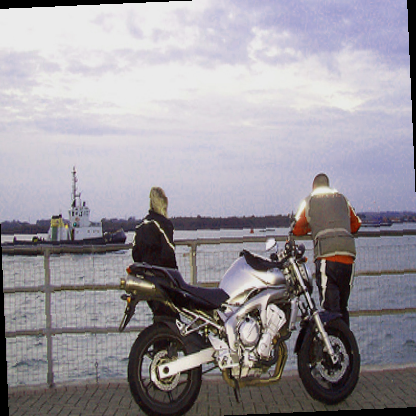

In [77]:
aa['image']

In [78]:
def img_show(x):
    image, label = x['image'], x['target']
    image_draw = ImageDraw.Draw(image)
    boxes = label['boxes']
    for box in boxes:
        image_draw.rectangle([(box[0],box[1]),(box[2],box[3])])
    image.show()

In [79]:
img_show(aa)

In [80]:
for i in range(10):
    x = dataset[i]
    img_show(x)

In [28]:
dir([])

[&#39;__add__&#39;,
 &#39;__class__&#39;,
 &#39;__contains__&#39;,
 &#39;__delattr__&#39;,
 &#39;__delitem__&#39;,
 &#39;__dir__&#39;,
 &#39;__doc__&#39;,
 &#39;__eq__&#39;,
 &#39;__format__&#39;,
 &#39;__ge__&#39;,
 &#39;__getattribute__&#39;,
 &#39;__getitem__&#39;,
 &#39;__gt__&#39;,
 &#39;__hash__&#39;,
 &#39;__iadd__&#39;,
 &#39;__imul__&#39;,
 &#39;__init__&#39;,
 &#39;__init_subclass__&#39;,
 &#39;__iter__&#39;,
 &#39;__le__&#39;,
 &#39;__len__&#39;,
 &#39;__lt__&#39;,
 &#39;__mul__&#39;,
 &#39;__ne__&#39;,
 &#39;__new__&#39;,
 &#39;__reduce__&#39;,
 &#39;__reduce_ex__&#39;,
 &#39;__repr__&#39;,
 &#39;__reversed__&#39;,
 &#39;__rmul__&#39;,
 &#39;__setattr__&#39;,
 &#39;__setitem__&#39;,
 &#39;__sizeof__&#39;,
 &#39;__str__&#39;,
 &#39;__subclasshook__&#39;,
 &#39;append&#39;,
 &#39;clear&#39;,
 &#39;copy&#39;,
 &#39;count&#39;,
 &#39;extend&#39;,
 &#39;index&#39;,
 &#39;insert&#39;,
 &#39;pop&#39;,
 &#39;remove&#39;,
 &#39;reverse&#39;,
 &#39;sort&#39;]

In [29]:
a = [1,2,3]

In [30]:
a.pop(1)

2

In [31]:
a

[1, 3]

In [41]:
a= torch.tensor([1])

In [43]:
b=a.copy_


In [46]:
b =a.copy_(a)

In [47]:
a

tensor([1])

In [48]:
b

tensor([1])